In [1]:
import nltk
from nltk.tokenize import wordpunct_tokenize
import pandas as pd
import matplotlib.pyplot as plt
import math
import subprocess
import tempfile
import os
import concurrent.futures as futs
%matplotlib inline

In [2]:
raw = pd.read_table("Raw Data/ar_reviews_100k.tsv")
raw.head()

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...


In [26]:
raw.iloc[[14399,14397, 14665, 14720, 16221, 17358, 19917, 35785, 42743, 47542, 50705, 51408]]

,label,text
14399,Positive,كتاب اكثر من رائع لا امل ابدا من قراءته انصح ا...
14397,Positive,الواقع
14665,Positive,جيد. قربه من مول الامارات.
14720,Positive,استثنائي. الخدمة الممتازة.
16221,Positive,جيد. . ضيق الغرفه
17358,Positive,اكثر من رائع . كل شي.
19917,Positive,اكثر من رائعه :
35785,Mixed,جيد جدا ..
42743,Mixed,كتاب دمة خفيف :
47542,Mixed,مقبول. . خدمات تنظيف الغرف


In [3]:
raw.loc[raw.text.str.match('[^ا-ي]')].iloc[0].text

'أحد أسباب نجاح الإمارات أن كل شخص في هذه الدولة يعشق ترابها. نحن نحب الإمارات. ومضات من فكر. نصائح لدولة تطمح بالصفوف الأولى و قائد لا يقبل إلا براحة شعبه وتوفر كل سب العيش الكريم. حكم و مواقف ونصائح لكل فرد فينا ليس بمجرد كتاب سياسي كما كنت اعتقد. يستحق القراءة مرات كثيرة'

In [4]:
print(raw.iloc[0].text)
wordpunct_tokenize(raw.iloc[0].text)

ممتاز نوعا ما . النظافة والموقع والتجهيز والشاطيء. المطعم


['ممتاز',
 'نوعا',
 'ما',
 '.',
 'النظافة',
 'والموقع',
 'والتجهيز',
 'والشاطيء',
 '.',
 'المطعم']

In [5]:
labelcounts = raw.label.value_counts()
labelcounts

Positive    33333
Mixed       33333
Negative    33333
Name: label, dtype: int64

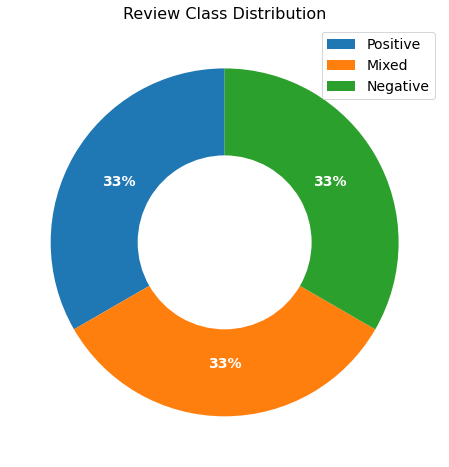

In [6]:
plt.figure(facecolor="white", figsize=(15,8))
wedges, texts, autotexts = plt.pie(labelcounts.values, wedgeprops=dict(width=0.5), startangle=90, autopct= lambda x: str(math.floor(x/1)) + '%', textprops={'color':'w'}, pctdistance=0.7)
plt.title("Review Class Distribution", fontsize=16)
plt.legend(labelcounts.index, fontsize=14)
plt.setp(autotexts, size=14, weight='bold')
plt.show()



In [7]:
# import json
# import requests
# url = "https://farasa.qcri.org/webapi/lemmatization/"
# text = raw.iloc[0].text
# api_key = "fbYdeESysyQpEiYEda"
# data = requests.post(url, data={'text':text, 'api_key': api_key})
# result = json.loads(data.text)
# print(result['text'])

In [8]:
lemmatized = []

In [9]:
def run(row):
    itmp = tempfile.NamedTemporaryFile(dir='./temp', delete=False)
    otmp = tempfile.NamedTemporaryFile(dir='./temp', delete=False)

    value = None
    try:
        itmp.write(str.encode(row[1].text))
        itmp.flush()
        proc = subprocess.run(
            ["java", "-Dfile.encoding=UTF-8", "-jar", "FarasaSegmenterJar.jar", '-l', 'true', '-i', itmp.name, '-o', otmp.name],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        if proc.returncode == 0:
            value = otmp.read().decode("utf8").strip()
        else:
            print(f"error occurred! stdout: , {proc.stdout},  stderr: , {proc.stderr}")
            print(f"return code: {proc.returncode}")
            raise Exception("Internal error occured")
    finally:
        itmp.close()
        otmp.close()
        os.unlink(itmp.name)
        os.unlink(otmp.name)

        return (row[0],value)

def populateLemmatized(value):
    lemmatized.append(value)


In [ ]:

if __name__ == "__main__":
    
    pool = futs.ThreadPoolExecutor()
    for row in raw[15951:].iterrows():

        future = pool.submit(run, row)
        future.add_done_callback(lambda x: populateLemmatized(x))
        




In [16]:
if __name__ == "__main__":
    
    pool = futs.ThreadPoolExecutor()
    for row in raw.iloc[[14397, 14665, 14720, 16221, 17358, 19917, 35785, 42743, 47542, 50705, 51408]].iterrows():

        future = pool.submit(run, row)
        future.add_done_callback(lambda x: populateLemmatized(x))

In [20]:

print(len(lemmatized))




11


In [21]:
lem_copy = lemmatized
new_lemmatized = []
for future in lem_copy:
    new_lemmatized.append(future.result())
new_lemmatized

[(17358, 'أكثر من رائع . كل شي .'),
 (14665, 'جيد . قرب من مول إمارة .'),
 (16221, 'جيد . . ضيق غرفة'),
 (14397, 'واقع'),
 (47542, 'مقبول . . خدمة تنظيف غرفة'),
 (42743, 'كتاب دم خفيف :'),
 (51408, 'مرض . . لايوجد مطعم'),
 (35785, 'جيد جد . .'),
 (50705, 'مقبول . موقع . خدمة'),
 (14720, 'استثنائي . خدمة ممتاز .'),
 (19917, 'أكثر من رائع :')]

In [22]:
import joblib
print(len(new_lemmatized))

joblib.dump(new_lemmatized,'Lem Files/lemmissing.joblib')


11


['lemmissing.joblib']

In [13]:
raw.iloc[4].text

'ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل الخدمات مريح نفسيا. لا يوجد'

24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


In [10]:
from tashaphyne.stemming import ArabicLightStemmer

stemmer = ArabicLightStemmer()

stemmer.light_stem(u"اوييييي")

stemmer.get_stem()

'ويييي'

In [2]:
from spellchecker import SpellChecker

checker = SpellChecker(language='ar')

checker.correction('جميل')

'جميل'